# Supervised Learning with Feedforward Neural Networks

Supervised machine learning is the type you probably already know about. The basic idea is that you have a set of inputs and a set of outputs, and you want to learn the relationship between them. For example, you might have a set of images of handwritten digits and you want to learn to recognize which digit is in each image. Or you might have a set of emails and you want to learn to recognize which ones are spam. Or you might have a set of audio clips and you want to learn to recognize what words were spoken in each clip.

*TLDR:* in supervised machine learning, we train an algorithm or neural network to predict outputs, given inputs.

The two basic types of supervised learning are:
- *Classfication:* outputs are discrete categories. For example, types of particles in the Standard Model, or handwritten digits.
- *Regression:* outputs are continuous or allow for interpolation, such as the mass of a particle or the price of a house.

## Classification: Some Simple Math Problems

We'll exemplify the idea in a simple problem: determining whether the product of two numbers $q_1$ and $q_2$ is positive.

We'll start by generating the data that models this problem.

In [1]:
!pip install torch torchvision torchsummary

In [2]:
from __future__ import print_function

import torch

import matplotlib
from mpl_toolkits.mplot3d import Axes3D

def f(q1, q2):
    return int(q1 * q2 > 0)

print(f(1,1), f(-1,1), f(0,1))

# generate our data set
x, y = [], []
for q1 in range(-5, 6):
    for q2 in range(-5, 6):
        x.append([q1, q2])
        y.append([f(q1, q2)])

x, y = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

1 0 0


Now we will set up the neural network. This takes in 2 numbers and will output one. 

You'll notice alternative sequences of linear layers and tanh non-linearities, similar to earlier in the course, but now we end with sigmoid:
$$\sigma(x) = \frac{1}{1+e^{-x}}$$
which is a non-linear function that maps any real number to a number between 0 and 1. This is useful for classification problems, since we can interpret the output as a probability.

In [3]:
# Set up and initialize the NN
width = 10
my_nn = torch.nn.Sequential(
    torch.nn.Linear(2,width),
    torch.nn.Tanh(),
    torch.nn.Linear(width,width),
    torch.nn.Tanh(),
    torch.nn.Linear(width,1),
    torch.nn.Sigmoid()
)

# this type of neural network is called a multilayer perceptron (MLP)
# a.k.a a fully connected neural network or a dense neural network
# or a feedforward neural network or a deep neural network

# the parameter 10 is called the hidden layer size or the number of neurons
# width

import torchsummary
torchsummary.summary(my_nn, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
              Tanh-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              Tanh-4                   [-1, 10]               0
            Linear-5                    [-1, 1]              11
           Sigmoid-6                    [-1, 1]               0
Total params: 151
Trainable params: 151
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Now set up some hyperparameters related to learning, the optimizer, and the loss function.

### **Loss function**
 we choose is typical for a binary classification problem such as this one. It is called the *binary cross entropy* and is defined as
$$L = -\frac{1}{N}\sum_{i=1}^N y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)$$
where $y_i$ is the true label (0 or 1) and $\hat{y}_i$ is the predicted label (between 0 and 1).

The basic idea of this loss is that if the true label is 1, then we want to maximize $\hat{y}_i$, and if the true label is 0, then we want to maximize $1-\hat{y}_i$. This is a good loss function for classification problems because it penalizes the network more for being very wrong than for being a little bit wrong. The value inside the log is effectively never exactly 0 or 1, so we don't have to worry about multiplying by infinity.

### **Optimizer**
We choose to use stochastic gradient descent, which differs from gradient descent due to mini-batches. The idea is that instead of computing the gradient of the loss function over the entire dataset, we compute it over a small subset of the dataset called a mini-batch. This is much faster, and the gradient is still a good approximation to the true gradient. The word "stochastic" refers to the fact that the mini-batches are often chosen randomly (though there are other ways for stochasticity to enter).

In [4]:
learning_rate = 0.01
epochs = 100

sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()

Time for the train loop.

In [5]:
avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat, y[i])
        loss.backward()
        avg_loss += loss.item()
        sgd.step()

    avg_losses.append(avg_loss / len(x))

print("\nTraining complete!")


Training complete!


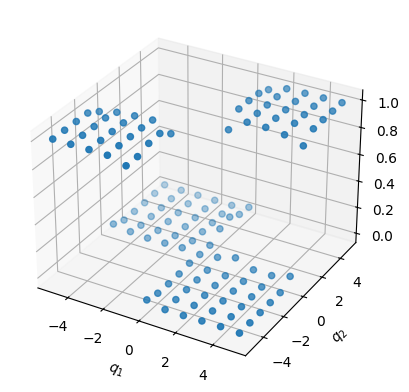

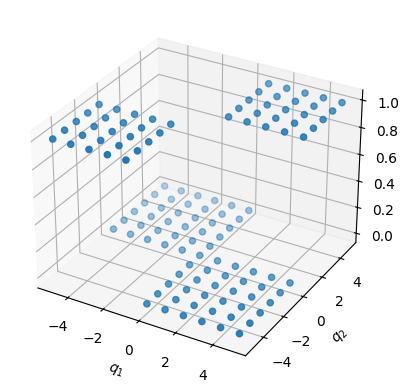

In [6]:
from matplotlib import pyplot as plt 

# Plot the loss during training
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_losses, 'o')  # show average losses
plt.title("Average losses per epoch")
plt.xlabel("Epochs")
plt.ylabel("Avg accuracy")
plt.yscale('log')
#plt.show()
plt.close()


# Plot prediction of NN
y_hat = my_nn(x)
x, y_hat = x.detach().numpy(), y_hat.detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([q[0] for q in x], [q[1] for q in x], [f for f in y_hat])
ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
ax.set_zlabel('y')
# plt.savefig("./example_1.1_prediction.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()


# Visualize with decision boundary 0.5
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([q[0] for q in x], [q[1] for q in x], [f.round() for f in y_hat])
ax.set_xlabel('$q_1$')
ax.set_ylabel('$q_2$')
ax.set_zlabel('y')
# plt.savefig("./example_1.1_prediction_rounded.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Three Classes

In this example we have three classes instead of two. Instead of sigmoid in the last layer, we will use softmax, which is a generalization of sigmoid to multiple classes. It is defined as
$$\sigma_i(x) = \frac{e^{x_i}}{\sum_{j=1}^N e^{x_j}}$$
where $x_i$ is the $i^\text{th}$ element of the input vector $x$ and $N$ is the number of classes. The output of the softmax is a vector of length $N$ whose elements sum to 1. We can interpret each element as the probability that the input belongs to the corresponding class.

Instead of binary cross-entropy loss, we'll use a natural generalization called *categorical cross-entropy* loss, which is defined as

$$L = -\frac{1}{N}\sum_{i=1}^N y_{i,j} \sum_j \log(\hat{y}_{i,j})$$

where $y_{i,j}$ is the true label (0 or 1) for the $i^{th}$ input and $j^{th}$ class, and $\hat{y}_{i,j}$ is the predicted label (between 0 and 1) for the $i^{th}$ input and $j^{th}$ class.

Why does this reproduce the binary cross entropy in the $j=2$ case? (Remember: y's are interpreted as probabilities).

In [31]:
# mod: the Austin experiment
width = 512
epochs = 200

def f(q1, q2):
    if q1*q2 < 0:
        return 0
    elif q1*q2 == 0:
        return 1
    else:
        return 2
    
my_nn = torch.nn.Sequential(
    torch.nn.Linear(2,width),
    torch.nn.Tanh(),
    torch.nn.Linear(width,width),
    torch.nn.Tanh(),
    torch.nn.Linear(width,3)
    # torch automatically applies softmax when using torch.nn.CrossEntropyLoss
)

sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

x, y = [], []
for q1 in range(-5, 6):
    for q2 in range(-5,6):
        x.append([q1,q2])
        y.append([f(q1,q2)])

x, y = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.long)

avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat.unsqueeze(0), y[i])
        loss.backward()
        avg_loss += loss.item()
        sgd.step()
    avg_losses.append(avg_loss / len(x))

print("\nTraining complete!")


Training complete!


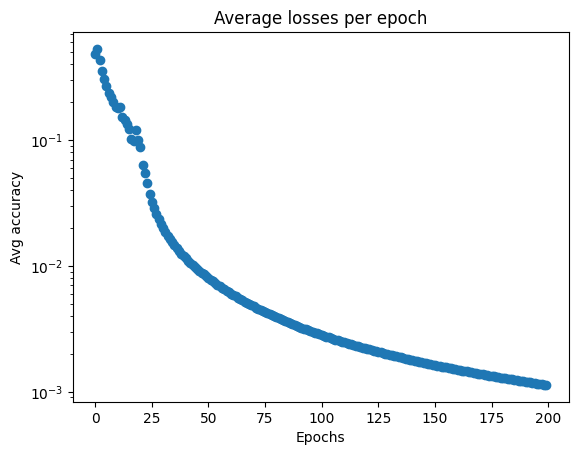

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_losses, 'o')  # show average losses
plt.title("Average losses per epoch")
plt.xlabel("Epochs")
plt.ylabel("Avg accuracy")
plt.yscale('log')
plt.show()

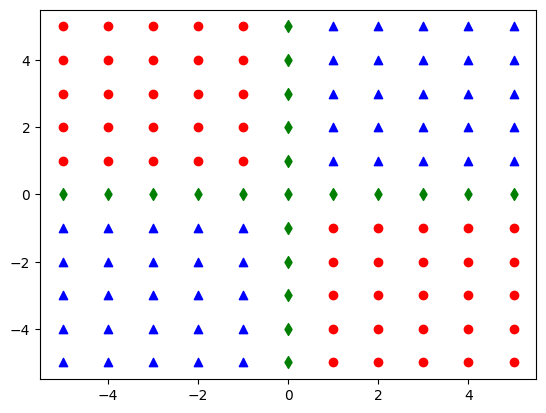

In [33]:
# plot the predictions
y_hat = my_nn(x).detach().numpy()
y_hat = y_hat.argmax(1)
x = x.detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter([x[i][0] for i in range(len(x)) if y_hat[i] == 0], [x[i][1] for i in range(len(x)) if y_hat[i] == 0], c='r', marker='o')
ax.scatter([x[i][0] for i in range(len(x)) if y_hat[i] == 1], [x[i][1] for i in range(len(x)) if y_hat[i] == 1], c='g', marker='d')
ax.scatter([x[i][0] for i in range(len(x)) if y_hat[i] == 2], [x[i][1] for i in range(len(x)) if y_hat[i] == 2], c='b', marker='^')
plt.show()

## Regression: $Z \to e^+ e^-$ decays

In this problem we'll use CERN OpenData taken from the website [opendata.cern.ch](http://opendata.cern.ch/record/545) to train a classifier to distinguish between $Z \to e^+ e^-$ decays and background events. The data is stored in the file `Zee.csv` and contains the following variables:
- `E1`, `E2`: The energy of the two electrons in GeV
- `pt1`, `pt2`: The transverse momentum of the two electrons in GeV
- `eta1`, `eta2`: The pseudorapidity of the two electrons
- `phi1`, `phi2`: The azimuthal angle of the two electrons
and some other data that won't be as relevant for us.

We will train a neural network to predict the invariant mass of the Z-boson from the transverse momenta `pt`, the pseudo-rapidities `eta` and the azimuthal angles `phi` of the electron and positron. The pseudo-rapidity is given by
$$\eta = -\ln(\tan(\theta/2))$$
where $\theta$ is the angle between the particle's momentum and the beam axis.
Of course, the exact formula for the invariant mass is known, but this is useful pedagogically because it will give us some confidence in the neural network.

In terms of these variables, the formula for the reconstructed invariant mass of the $Z$-boson is 
$M_Z^2 = 2 p_{T,1} p_{T,2} ( \cosh(\eta_1 - \eta_2) - \cos(\phi_1 - \phi_2))$.


We begin with some imports and implementing a function for the invariant mass.

In [14]:
from __future__ import print_function

import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

def get_invariant_mass(pt1,pt2,eta1,eta2,phi1,phi2):
    return np.sqrt(2*pt1*pt2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2)))


### Attempt 1: No normalization on the inputs

In [15]:
x, y = [], []
zee_data = pd.read_csv("Zee.csv")
inv_mass = get_invariant_mass(zee_data.pt1, zee_data.pt2, zee_data.eta1, zee_data.eta2, zee_data.phi1, zee_data.phi2)
for index, row in zee_data.iterrows():
    x.append([row.pt1, row.pt2, row.eta1, row.eta2, row.phi1, row.phi2])

x = np.asarray(x)
y = np.asarray([[y] for y in inv_mass])
x, y = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

## set up neural network
my_nn = torch.nn.Sequential(
    torch.nn.Linear(6,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,1)
)

## set up otpimizer
epochs = 20
learning_rate = 0.0001
sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# train loop
avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat,y[i])
        loss.backward()
        avg_loss += loss.item()
        sgd.step()
    avg_losses.append(avg_loss / len(x))
    print("Epoch {:3d}: MSE Loss {:5f}".format(epoch, avg_loss / len(x)))

print("Training complete!")

Epoch   0: MSE Loss 379.135825
Epoch   1: MSE Loss 149.465649
Epoch   2: MSE Loss 149.388768
Epoch   3: MSE Loss 149.387606
Epoch   4: MSE Loss 149.386478
Epoch   5: MSE Loss 149.385382
Epoch   6: MSE Loss 149.384306
Epoch   7: MSE Loss 149.383255
Epoch   8: MSE Loss 149.382224
Epoch   9: MSE Loss 149.381213
Epoch  10: MSE Loss 149.380217
Epoch  11: MSE Loss 149.379237
Epoch  12: MSE Loss 149.378266
Epoch  13: MSE Loss 149.377309
Epoch  14: MSE Loss 149.376362
Epoch  15: MSE Loss 149.375424
Epoch  16: MSE Loss 149.374496
Epoch  17: MSE Loss 149.373571
Epoch  18: MSE Loss 149.372655
Epoch  19: MSE Loss 149.371743
Training complete!


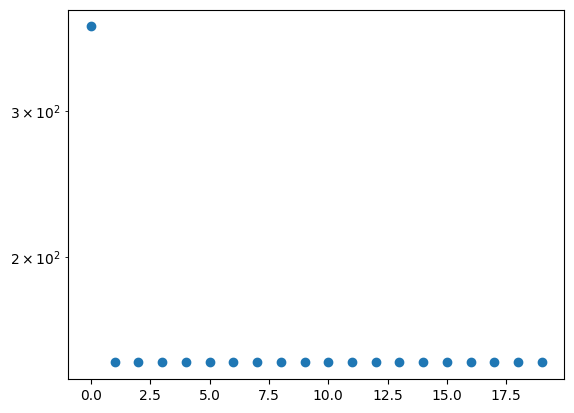

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_losses, 'o')
plt.yscale('log')
plt.show()

In [18]:
print(x.shape)

torch.Size([10000, 6])


/var/folders/wz/s4rx21_137g79thgtc1s1k3m0000gn/T/ipykernel_97980/2881999065.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i]) for i in range(len(y_hat))], c='r', marker='o')


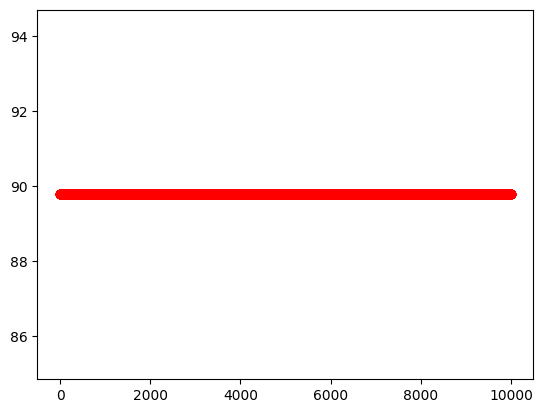

In [20]:
y_hat = my_nn(x)
x, y_hat = x.detach().numpy(), y_hat.detach().numpy()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i]) for i in range(len(y_hat))], c='r', marker='o')
plt.show()

/var/folders/wz/s4rx21_137g79thgtc1s1k3m0000gn/T/ipykernel_97980/1468101641.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))], c='r', marker='o')


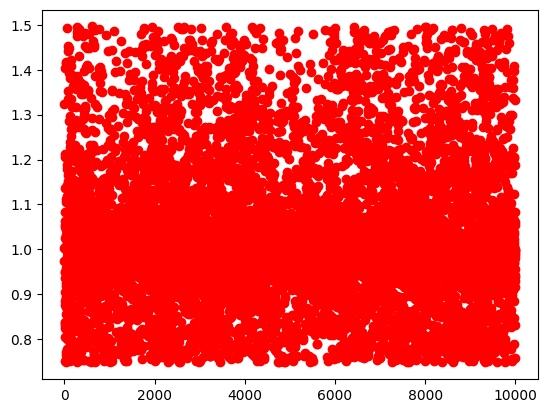

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))], c='r', marker='o')
plt.show()

### Attempt 2: Normalize the data a bit

In [28]:
x, y = [], []
zee_data = pd.read_csv("Zee.csv")
inv_mass = get_invariant_mass(zee_data.pt1, zee_data.pt2, zee_data.eta1, zee_data.eta2, zee_data.phi1, zee_data.phi2)
for index, row in zee_data.iterrows():
    x.append([row.pt1/100., row.pt2/100., row.eta1, row.eta2, row.phi1, row.phi2])

x = np.asarray(x)
y = np.asarray([[y] for y in inv_mass])
x, y = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

## set up neural network
my_nn = torch.nn.Sequential(
    torch.nn.Linear(6,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,1)
)

## set up otpimizer
epochs = 20
learning_rate = 0.0001
sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# train loop
avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat,y[i])
        loss.backward()
        avg_loss += loss.item()
        sgd.step()
    avg_losses.append(avg_loss / len(x))
    print("Epoch {:3d}: MSE Loss {:5f}".format(epoch, avg_loss / len(x)))

print("Training complete!")

Epoch   0: MSE Loss 135.073553
Epoch   1: MSE Loss 74.910963
Epoch   2: MSE Loss 66.383188
Epoch   3: MSE Loss 48.397450
Epoch   4: MSE Loss 35.256847
Epoch   5: MSE Loss 30.094924
Epoch   6: MSE Loss 27.820244
Epoch   7: MSE Loss 25.100280
Epoch   8: MSE Loss 22.988041
Epoch   9: MSE Loss 20.694927
Epoch  10: MSE Loss 18.921046
Epoch  11: MSE Loss 17.361081
Epoch  12: MSE Loss 15.742802
Epoch  13: MSE Loss 14.229188
Epoch  14: MSE Loss 12.656743
Epoch  15: MSE Loss 11.108162
Epoch  16: MSE Loss 9.756361
Epoch  17: MSE Loss 8.393786
Epoch  18: MSE Loss 7.456760
Epoch  19: MSE Loss 6.675765
Training complete!


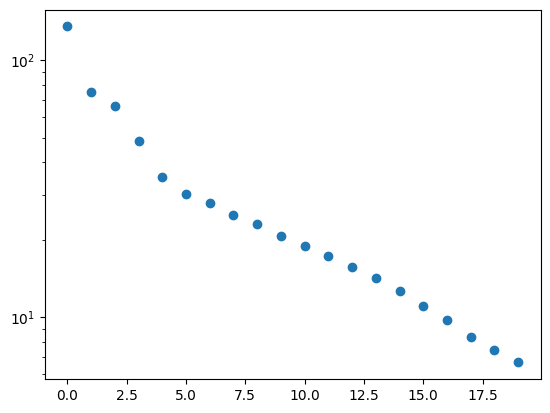

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(avg_losses, 'o')
plt.yscale('log')
plt.show()

/var/folders/wz/s4rx21_137g79thgtc1s1k3m0000gn/T/ipykernel_97980/2346269407.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i]) for i in range(len(y_hat))], c='r', marker='o')


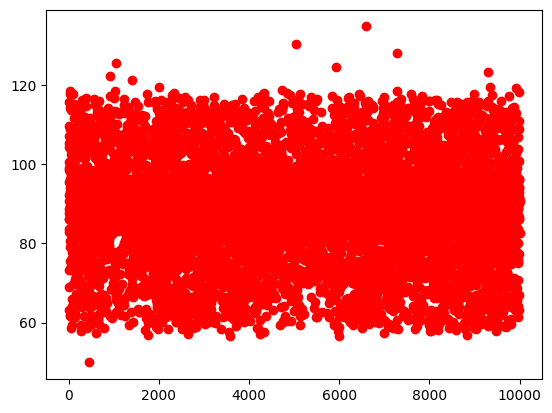

/var/folders/wz/s4rx21_137g79thgtc1s1k3m0000gn/T/ipykernel_97980/2346269407.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y[i].detach().numpy()) for i in range(len(y))], c='r', marker='o')


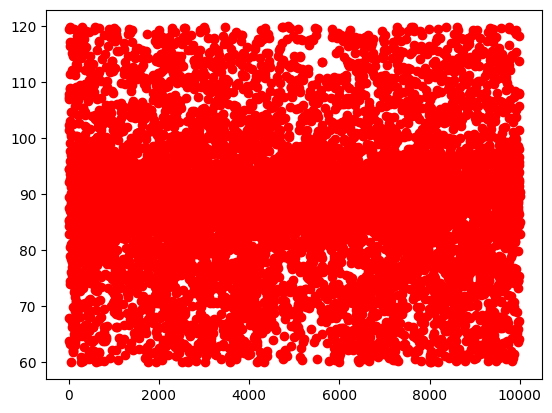

/var/folders/wz/s4rx21_137g79thgtc1s1k3m0000gn/T/ipykernel_97980/2346269407.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))], c='r', marker='o')


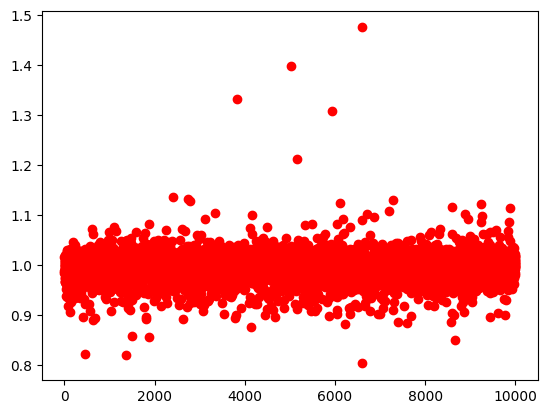

In [30]:
y_hat = my_nn(x)
x, y_hat = x.detach().numpy(), y_hat.detach().numpy()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i]) for i in range(len(y_hat))], c='r', marker='o')
plt.show()

# plot the truth
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y[i].detach().numpy()) for i in range(len(y))], c='r', marker='o')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))], c='r', marker='o')
plt.show()

### Attempt 3: Use the Physically Sensible Variables

In [31]:
x, y = [], []
zee_data = pd.read_csv("Zee.csv")
inv_mass = get_invariant_mass(zee_data.pt1, zee_data.pt2, zee_data.eta1, zee_data.eta2, zee_data.phi1, zee_data.phi2)
for index, row in zee_data.iterrows():
    x.append([row.pt1/100. * row.pt2/100., abs(row.eta1- row.eta2), abs(row.phi1- row.phi2)])

x = np.asarray(x)
y = np.asarray([[y] for y in inv_mass])
x, y = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

## set up neural network
my_nn = torch.nn.Sequential(
    torch.nn.Linear(3,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,1)
)

## set up otpimizer
epochs = 20
learning_rate = 0.0001
sgd = torch.optim.SGD(my_nn.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# train loop
avg_losses = []
for epoch in range(epochs):
    avg_loss = 0
    for i in range(len(x)):
        sgd.zero_grad()
        y_hat = my_nn(x[i])
        loss = criterion(y_hat,y[i])
        loss.backward()
        avg_loss += loss.item()
        sgd.step()
    avg_losses.append(avg_loss / len(x))
    print("Epoch {:3d}: MSE Loss {:5f}".format(epoch, avg_loss / len(x)))

print("Training complete!")

Epoch   0: MSE Loss 140.441783
Epoch   1: MSE Loss 91.847408
Epoch   2: MSE Loss 68.307521
Epoch   3: MSE Loss 58.518661
Epoch   4: MSE Loss 53.985464
Epoch   5: MSE Loss 51.237161
Epoch   6: MSE Loss 50.668794
Epoch   7: MSE Loss 45.309357
Epoch   8: MSE Loss 31.639637
Epoch   9: MSE Loss 20.385587
Epoch  10: MSE Loss 13.871679
Epoch  11: MSE Loss 11.605109
Epoch  12: MSE Loss 8.830371
Epoch  13: MSE Loss 7.973165
Epoch  14: MSE Loss 6.224212
Epoch  15: MSE Loss 5.560726
Epoch  16: MSE Loss 4.870586
Epoch  17: MSE Loss 4.335656
Epoch  18: MSE Loss 4.268441
Epoch  19: MSE Loss 3.814508
Training complete!


/var/folders/wz/s4rx21_137g79thgtc1s1k3m0000gn/T/ipykernel_97980/2346269407.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i]) for i in range(len(y_hat))], c='r', marker='o')


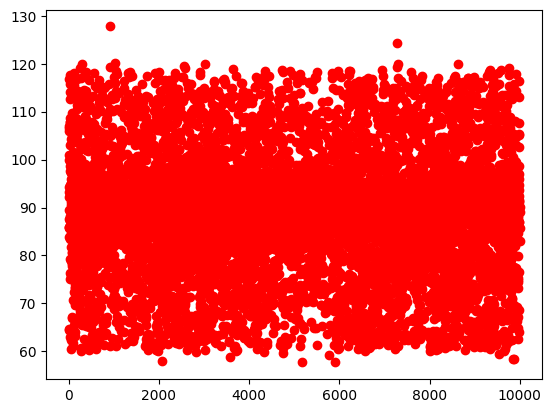

/var/folders/wz/s4rx21_137g79thgtc1s1k3m0000gn/T/ipykernel_97980/2346269407.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y[i].detach().numpy()) for i in range(len(y))], c='r', marker='o')


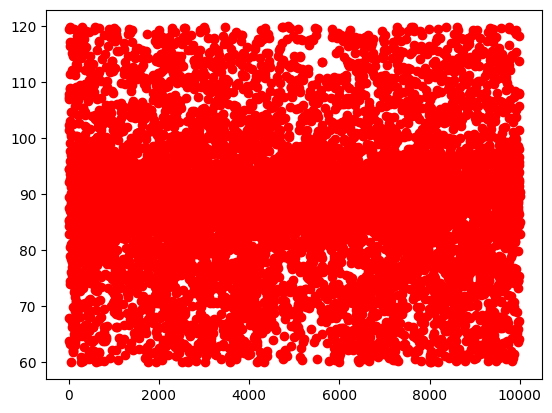

/var/folders/wz/s4rx21_137g79thgtc1s1k3m0000gn/T/ipykernel_97980/2346269407.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))], c='r', marker='o')


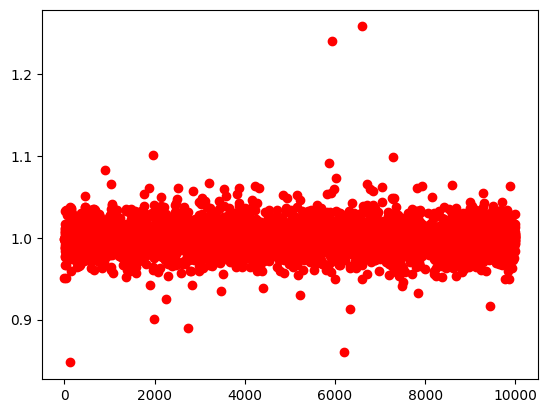

In [32]:
y_hat = my_nn(x)
x, y_hat = x.detach().numpy(), y_hat.detach().numpy()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i]) for i in range(len(y_hat))], c='r', marker='o')
plt.show()

# plot the truth
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y[i].detach().numpy()) for i in range(len(y))], c='r', marker='o')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(y_hat)), [float(y_hat[i])/float(y[i]) for i in range(len(y_hat))], c='r', marker='o')
plt.show()